In [43]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts



In [78]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = pd.read_csv('P_agg_data_for_prediction.csv', engine='python', skipfooter=3)
df

,measurement,appliance,value,timestamp
0,Electricity,P_agg,105.183,1661990400
1,Electricity,P_agg,105.224,1661990430
2,Electricity,P_agg,106.171,1661990460
3,Electricity,P_agg,105.903,1661990490
4,Electricity,P_agg,105.970,1661990520
...,...,...,...,...
1049310,Electricity,P_agg,1029.913,1693526160
1049311,Electricity,P_agg,1030.499,1693526190
1049312,Electricity,P_agg,1030.900,1693526220
1049313,Electricity,P_agg,1028.714,1693526250


In [79]:
# Convert 'timestamp' to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as index for resampling
df.set_index('datetime', inplace=True)

# Resample to daily sum of 'value' in kilowatts (kWh)
daily_df = df.resample('1D').sum(numeric_only=True)
daily_df['value'] = daily_df['value'] / 1000  # Convert from Wh to kWh


# Reset index to turn datetime back into a column
daily_df = daily_df.reset_index()

# Add iteration column
daily_df['iteration'] = range(len(daily_df))

# Reorder columns
daily_df = daily_df[['iteration', 'datetime', 'value']]

# Final result
print(daily_df)

     iteration   datetime        value
0            0 2022-09-01  1075.340479
1            1 2022-09-02  3319.990097
2            2 2022-09-03  2197.876380
3            3 2022-09-04  2637.341984
4            4 2022-09-05   336.764387
..         ...        ...          ...
360        360 2023-08-27   819.087481
361        361 2023-08-28  1783.522167
362        362 2023-08-29  2796.125353
363        363 2023-08-30  2478.858460
364        364 2023-08-31  1331.943858

[365 rows x 3 columns]


In [80]:
tseries= daily_df.drop('datetime', axis=1)
tseries = tseries.drop('iteration', axis=1)
df=pd.DataFrame(tseries)
df

,value
0,1075.340479
1,3319.990097
2,2197.876380
3,2637.341984
4,336.764387
...,...
360,819.087481
361,1783.522167
362,2796.125353
363,2478.858460


In [34]:
df=pd.DataFrame(df)
df.to_csv("daily kilowatt consumption.csv")

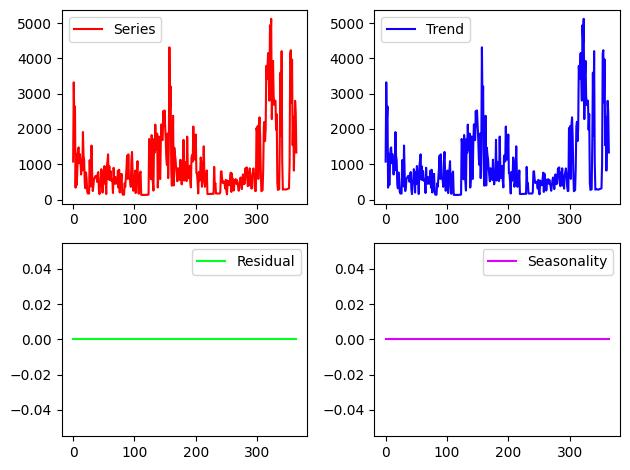

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(df['value'], model='additive', period=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(df['value'],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

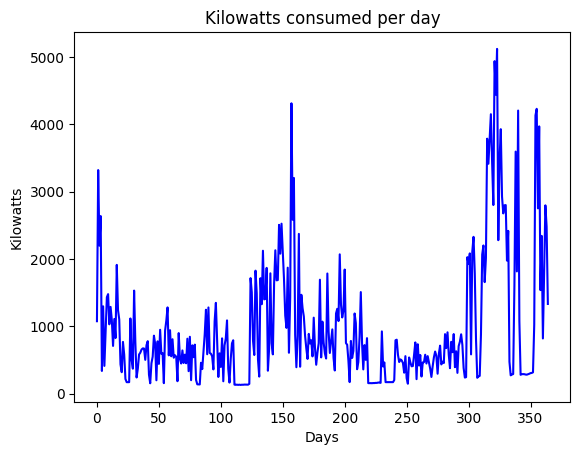

In [49]:
plt.plot(df['value'], color='blue', label='Daily Kilowatt Consumption')
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Kilowatts consumed per day")
plt.show()

In [81]:
train_df=df[:int(len(df)*0.8)]
train_df

,value
0,1075.340479
1,3319.990097
2,2197.876380
3,2637.341984
4,336.764387
...,...
287,615.102290
288,884.391439
289,392.726855
290,628.325686


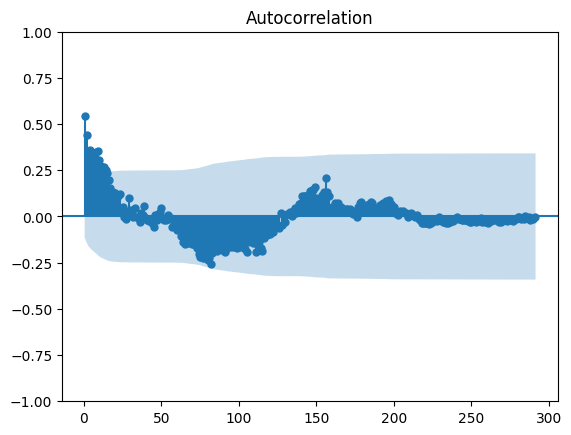

In [82]:
plot_acf(train_df, lags=291, zero=False);

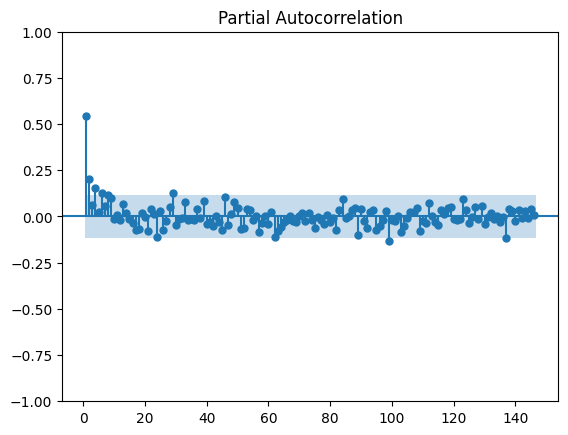

In [72]:
plot_pacf(train_df, lags=146, zero=False);

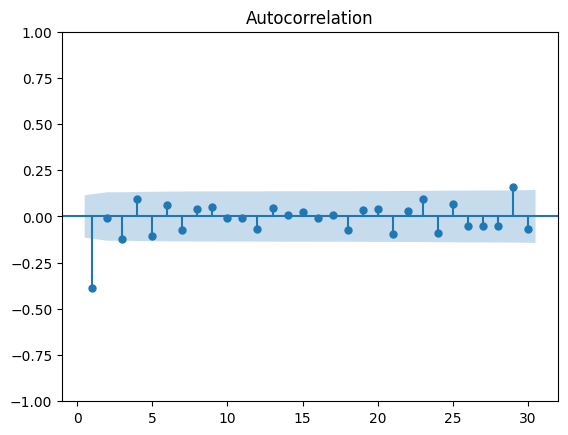

In [66]:
plot_acf(np.diff(train_df['value'], 1), lags=30, zero=False);

In [61]:
# Examine ACF values to find optimal window size
from statsmodels.tsa.stattools import acf

# Calculate ACF values
acf_values = acf(train_df['value'], nlags=30, fft=False)

# Find where ACF drops below significance threshold (typically 0.2 or confidence interval)
significant_lags = []
for i, val in enumerate(acf_values[1:], 1):  # Skip lag 0
    if abs(val) > 0.2:  # Adjust threshold as needed
        significant_lags.append(i)

print(f"Significant lags: {significant_lags}")
print(f"Suggested window size based on last significant lag: {max(significant_lags) if significant_lags else 7}")

# For energy consumption data, common window sizes are:
# - 7 days (weekly pattern)
# - 14 days (bi-weekly)
# - 30 days (monthly)

Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Suggested window size based on last significant lag: 15


In [56]:
test_df=df[len(train_df):len(df)]
test_df

,value
292,705.726843
293,772.556652
294,880.847010
295,723.420203
296,381.038365
...,...
360,819.087481
361,1783.522167
362,2796.125353
363,2478.858460


In [67]:
window_size = 15

# Extract the 'value' column as a Series
numbers_series = train_df['value']
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7 = np.array(ts7)
print(ts7)

[1355.2890754  1338.61659204 1244.74991194 1180.92744394 1078.62204288
 1085.16911476 1019.95533468 1043.69563378 1021.27771324  940.28300241
  853.11053118  795.81077958  721.28798868  722.66806703  708.59850123
  659.41669743  706.39758171  629.64776971  562.92565828  514.14116401
  523.88319173  543.1854082   535.62637787  541.85524597  572.04155197
  594.139058    630.78302243  671.35248517  615.66298573  592.75096563
  598.18065287  532.79093878  539.44527538  572.90295074  561.37741249
  574.40121707  563.31609299  582.89815902  577.54037362  573.00707279
  549.93057152  564.22600857  584.60203251  651.24047161  678.87702027
  711.54936021  711.9214116   708.38572013  694.4761594   719.24679205
  703.97351827  686.84172488  683.55477925  678.51316835  668.18168542
  700.56970309  668.64319131  634.94592235  579.63073531  596.12716345
  555.57416311  574.88174498  534.32645871  546.60612765  544.69019718
  556.69550888  557.97809821  507.25331541  482.03541442  461.32593494
  449.

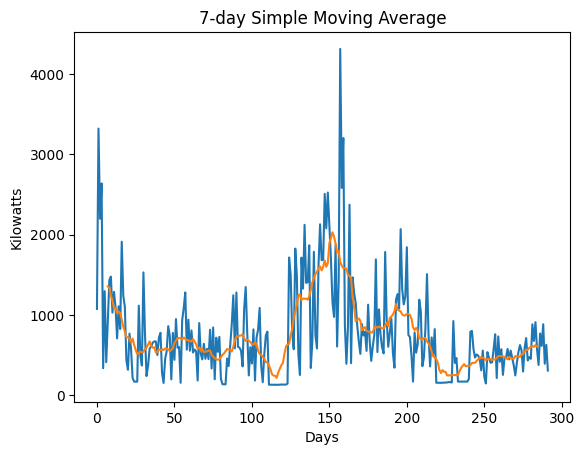

In [68]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("7-day Simple Moving Average")
plt.show()

In [69]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-6.95247135941813,
 9.613967242098086e-10,
 1,
 290,
 {'1%': -3.453102162983312,
  '5%': -2.871558538275452,
  '10%': -2.5721082282996433},
 4401.2265604195545)

In [70]:
Arima_model=pm.auto_arima(train_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=15, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=4464.463, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=4351.229, Time=0.59 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[15]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=4421.515, Time=0.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[15]             : AIC=4336.470, Time=1.74 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[15]             : AIC=4324.204, Time=2.51 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(4,1,0)[15]             : AIC=4317.608, Time=7.01 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 